## (1) Read data into pandas dataframe.

In [1]:
import pandas as pd
import nltk
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\bloom\Documents\GitHub\SPS_MSDS_SMR21_DATA620\Data\fine_food_rawsample.csv")

In [3]:
print("Total Reviews")
print(len(df))
print("Distinct Products")
print(len(df['product/productId'].unique()))
print("Distinct Reviewers")
print(len(df['review/userId'].unique()))

Total Reviews
5685
Distinct Products
4209
Distinct Reviewers
5439


We see that there nearly every review is for a unique a product. If we had more reviews per product, we might be able to do an analysis based on aggregate review and consistency of word use. We still have plenty of options in this case, however.

## (2) Conduct sentiment analysis of the review texts to assign a classification and score.

We have a field for Review/Summary and a second field for Review/Text, I believe these are the bold part of the review you see on Amazon, and then the exposition below. We may as well concatenate these strings together for a larger sample per review.

In [4]:
df['review'] = df['review/summary'] + " " + df['review/text'] 

With a more robust review field, we will proceed by cleaning and tokenizing our review data. I borrowed a bit from [toward data science](https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e) to tokenize our reviews and flag with POS in a systematic way. 

In [5]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

    
def clean(i):
    i = str(i).lower()
    i = [j.strip(string.punctuation) for j in i.split(" ")]
    i = [j for j in i if not any(c.isdigit() for c in j)]
    s = stopwords.words('english')
    i = [x for x in i if x not in s]
    i = [t for t in i if len(t) > 0]
    pos_tags = pos_tag(i)
    i = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    i = [t for t in i if len(t) > 1]
    i = " ".join(i)
    return(i)

# clean text data
df["review_clean"] = df["review"].apply(lambda x: clean(x))

Now we can use NLTK's VADER (Valence Aware Dictionary for Sentiment Reasoning) to assign Sentiment values

In [7]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bloom\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [9]:
# I beleive this is a very "R" way of doing this. It works in Python but shows a warning. 
# Following code supresses warning 
import warnings
warnings.filterwarnings('ignore')

df['negative'] = ""
df['neutral'] = ""
df['positive'] = ""
df['compound'] = ""

for i in range(len(df)):
    sentiment = sia.polarity_scores(df['review_clean'][i])
    df['negative'][i] = sentiment['neg']
    df['neutral'][i] = sentiment['neu']
    df['positive'][i] = sentiment['pos']
    df['compound'][i] = sentiment['compound']


Vader provides a percent probability for Positive, Negative and Neutral values, such that the sum is 100%. It also provides a Compound score ranging from -1 to 1. I included the Positive/Negative/Neutral scores, however, we will focus on the compound score. Anything over 50% will be flagged as positive, with anything under 50% as negative. The middle range we will flag as neutral or unknown.

In [10]:
conditions = [
    (df['compound'] >= .5),
    (df['compound'] <= -.5),
    (df['compound'] < .5) & (df['compound'] > -.5)]

values = ['Positive', 'Negative', 'Neutral/Unknown']

df['Sentiment'] = np.select(conditions, values)

Similarly, we will treat any review with exactly 3 stars (as given by the user) as Neutral. Anything over as Positive and under as negative. 

In [11]:
conditions = [
    (df['review/score'] > 3),
    (df['review/score'] < 3),
    (df['review/score'] ==  3)]

values = ['Positive', 'Negative', 'Neutral/Unknown']

df['Rating_Sentiment'] = np.select(conditions, values)

In [12]:
print(df.groupby('Rating_Sentiment')['product/productId'].count())
print("")
print(df.groupby(['Sentiment','Rating_Sentiment'])['product/productId'].count())

Rating_Sentiment
Negative            800
Neutral/Unknown     428
Positive           4457
Name: product/productId, dtype: int64

Sentiment        Rating_Sentiment
Negative         Negative             143
                 Neutral/Unknown       21
                 Positive              31
Neutral/Unknown  Negative             272
                 Neutral/Unknown       70
                 Positive             235
Positive         Negative             385
                 Neutral/Unknown      337
                 Positive            4191
Name: product/productId, dtype: int64


## (3) Explore results, apply visualizations to understand the distribution of sentiment, and decide if the chosen classifications are useful or need to be redifined in step 2.

We see that most of our reviews are positive. That being said, Vader seems to be great at selecting which reviews are positive. Due to the overwhelming number of positive reviews, lets restructure this data such that we are interesting in flagging reviews as "positive" or "other" and structure our analysis this way. 

In [13]:
df['Positive_Sentiment'] = df['compound']>.5
df['Positive_Review'] = df['review/score']>3

In [14]:
print(df.groupby(['Positive_Review','Positive_Sentiment'])['product/productId'].count())

Positive_Review  Positive_Sentiment
False            False                  506
                 True                   722
True             False                  266
                 True                  4191
Name: product/productId, dtype: int64


Not bad! Lets calculate sensitivity and specificity. We will assume our model is trying to predict reviews which were rated positively by the review.

In [15]:
conditions = [
    (df['Positive_Sentiment'] == True) & (df['Positive_Review'] == True),
    (df['Positive_Sentiment'] == True) & (df['Positive_Review'] == False),
    (df['Positive_Sentiment'] == False) & (df['Positive_Review'] == True),
    (df['Positive_Sentiment'] == False) & (df['Positive_Review'] == False)]

values = ['TP', 'FP', 'FN', 'TN']

df['Category'] = np.select(conditions, values)

In [16]:
TP = len(df[df['Category']=="TP"])
FP = len(df[df['Category']=="FP"])
TN = len(df[df['Category']=="TN"])
FN = len(df[df['Category']=="FN"])


In [17]:
print("Sensitivity, percentage of reviews rated positive by the user that sentiment anaysis labled as positive:")
print(TP/(TP+FN))
print("")
print("Specificity, percentage of reviews rated negative (under 4 stars) by the user that sentiment anaysis labled as negative:")
print(TN/(TN+FP))
print("")
print("Percision, percentage of reviews rated positive by sentiment anaysis that the user rated as positive")
print(TP/(TP+FP))

Sensitivity, percentage of reviews rated positive by the user that sentiment anaysis labled as positive:
0.9403185999551268

Specificity, percentage of reviews rated negative (under 4 stars) by the user that sentiment anaysis labled as negative:
0.41205211726384366

Percision, percentage of reviews rated positive by sentiment anaysis that the user rated as positive
0.8530429472827193


One additional analysis I am interested in is review length. I suspect that short positive reviews may not contain enough positive words to be labeled as such by our model.

In [18]:
# Assuming there is exactly one space between each word, which we know that there is per our cleaning of the data. 
df['review length'] =df['review_clean'].str.count(' ') + 1

In [19]:
df.groupby(['Category'])['review length'].mean()

Category
FN    33.556391
FP    59.296399
TN    38.628458
TP    43.834646
Name: review length, dtype: float64

In [20]:
df.groupby(['Category'])['review length'].median()

Category
FN    23
FP    42
TN    28
TP    31
Name: review length, dtype: int64

**Review to make sure this holds true as sample changes** 

Interestingly enough, False Positives have the largest word count. It seems as though as reviews get longer, sentiment analysis becomes less accurate.  

# 3.b Visuals / Analysis

## Language

**20 Most Common Words in Dataset** 

In [21]:
# Join questions into long string 
word_list = ' '.join(df['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])


['like',
 'good',
 'taste',
 'great',
 'love',
 'flavor',
 'one',
 'product',
 'get',
 'use',
 'coffee',
 'make',
 'tea',
 'food',
 'try',
 'buy',
 'find',
 'would',
 'dog',
 'well']

**20 Most Common Words in True Positive Reviews** 

In [22]:
# Join questions into long string 
word_list = ' '.join(df[df['Category']=='TP']['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])


['like',
 'great',
 'good',
 'love',
 'taste',
 'flavor',
 'one',
 'tea',
 'use',
 'coffee',
 'make',
 'get',
 'product',
 'food',
 'find',
 'try',
 'best',
 'well',
 'buy',
 'dog']

**20 Most Common Words in True Negative Reviews** 

In [23]:
# Join questions into long string 
word_list = ' '.join(df[df['Category']=='TN']['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])

['taste',
 'product',
 'like',
 'one',
 'get',
 'food',
 'buy',
 'would',
 'bad',
 'coffee',
 'flavor',
 'make',
 'try',
 'use',
 'order',
 'good',
 'give',
 'eat',
 'even',
 'think']

**20 Most Common Words in False Negative or False Positive Reviews** 

In [24]:
# Join questions into long string 
word_list = ' '.join(df[((df['Category']=='FN') | (df['Category']=='FP'))]['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])

['like',
 'taste',
 'good',
 'product',
 'flavor',
 'food',
 'get',
 'one',
 'would',
 'use',
 'make',
 'coffee',
 'buy',
 'try',
 'dog',
 'eat',
 'tea',
 'well',
 'time',
 'cat']

### Word Cloud 
Let's generate a word cloud for each of our categories:

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# dataset.drop(['labels'], axis = 1, inplace = True)

### True Positives

Reviews our model correctly identified as positive.

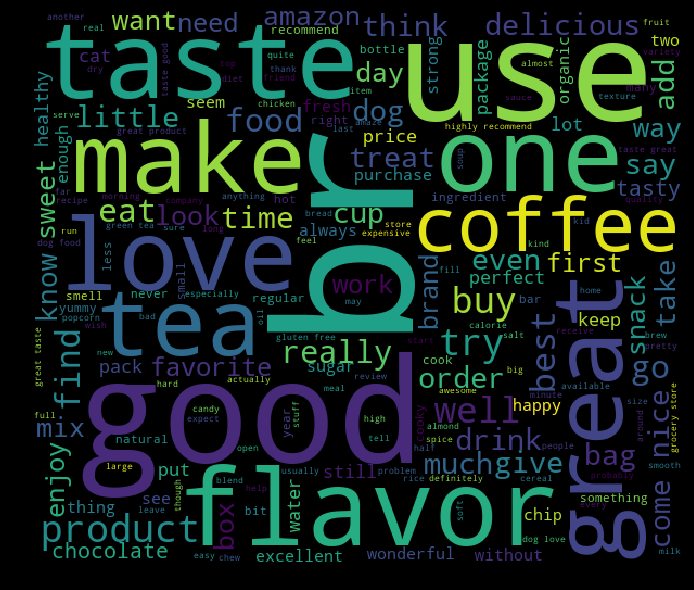

In [26]:
words = ' '.join((df[df['Category']=='TP']['review_clean']))
words = words.split()
words = [x for x in words if x != 'br']
words = [x for x in words if "b r" not in x]
words =  ' '.join(words)
words_wc = WordCloud(width = 600,height = 512).generate(words)
plt.figure(figsize = (12, 8), facecolor = 'k')
plt.imshow(words_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### True Negatives

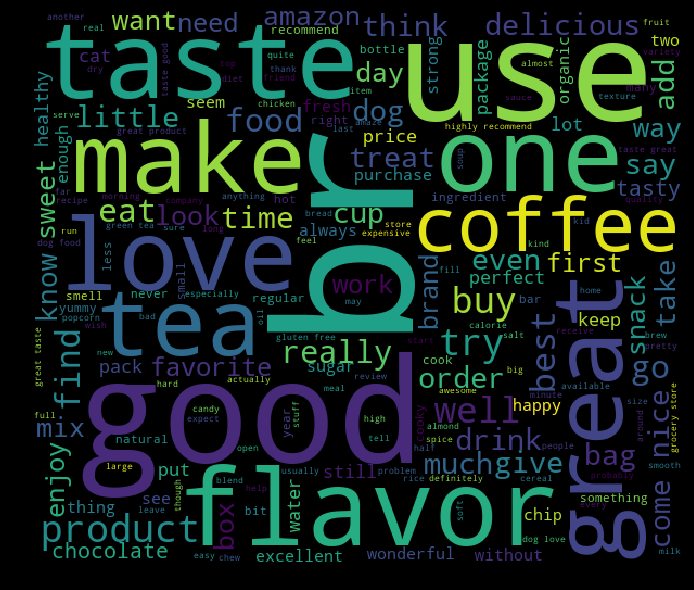

In [27]:
words = ' '.join(list(df[df['Category']=='TN']['review_clean']))
words = words.split()
words = [x for x in words if x != 'br']
words = [x for x in words if "b r" not in x]
words =  ' '.join(words)
plt.figure(figsize = (12, 8), facecolor = 'k')
plt.imshow(words_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Flase Negatives / False Positives 
Reviews our model miscatergorized wrong

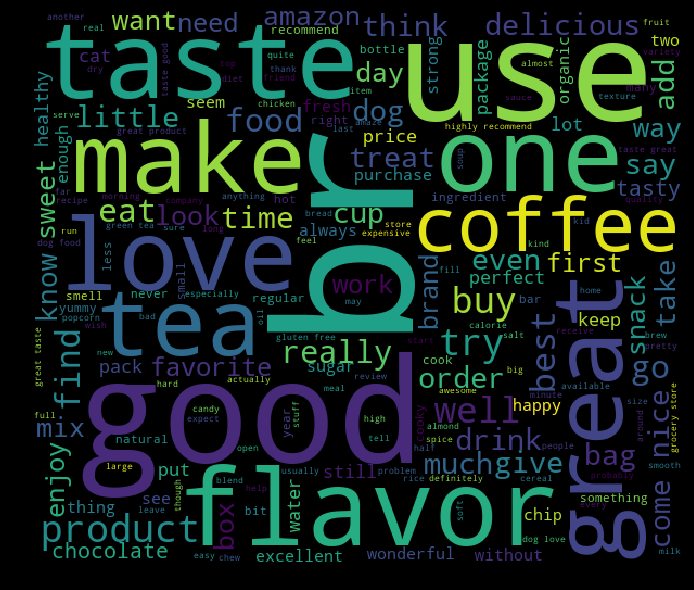

In [28]:
words = ' '.join(list(df[((df['Category']=='FN') | (df['Category']=='FP'))]['review_clean']))
words = words.split()
words = [x for x in words if x != 'br']
words = [x for x in words if "b r" not in x]
words =  ' '.join(words)
plt.figure(figsize = (12, 8), facecolor = 'k')
plt.imshow(words_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Metric Visualizations

### Confusion Matrix

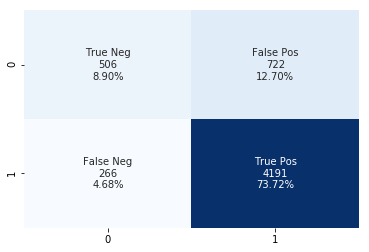

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import seaborn as sns

cf_matrix = confusion_matrix(df['Positive_Review'], df['Positive_Sentiment'])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)


**"Comound" Sentiment Results:**

Score of 0 is netural, 1 = 100% confident review is positive, 0 = 100% confident review is negative

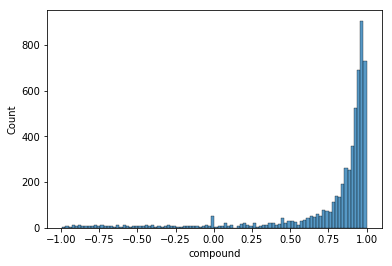

In [33]:
sns.histplot(data=df, x="compound")

**User given review vs model results**

Stacked barplot. 

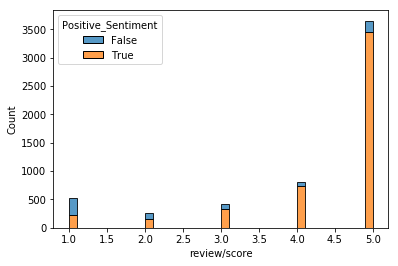

In [39]:
sns.histplot(data=df, x="review/score", hue='Positive_Sentiment', multiple="stack")

**Positive Sentiment per model vs Postive Review per user** 

Stacked barplot, alternative to confusion matrix. 

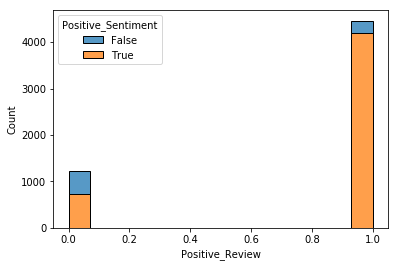

In [41]:
sns.histplot(data=df, x="Positive_Review", hue='Positive_Sentiment', multiple="stack")

**Word Count by Category**

[(0, 200)]

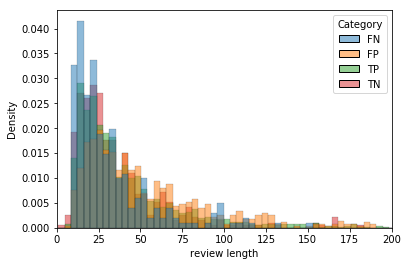

In [56]:
sns.histplot(data=df, x="review length", hue='Category', stat='density',  common_norm=False).set(xlim=(0, 200))

That was a little hard to read - lets break it down into correctly predicted vs incorrectly predicted:

[(0, 200)]

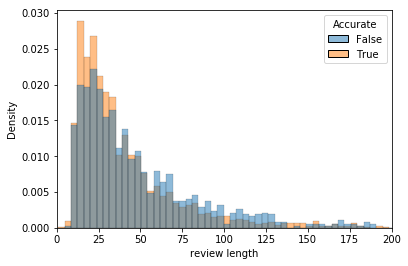

In [65]:
conditions = [
    (df['Category'] == "TP") | (df['Category'] == "TN"),
     (df['Category'] == "FP") | (df['Category'] == "FN")]

values = ["True", "False"]

df['Accurate'] = np.select(conditions, values)

sns.histplot(data=df, x="review length", hue='Accurate', stat='density',  common_norm=False).set(xlim=(0, 200))